In [1]:
# Import the libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.strtree import STRtree

In [2]:
# Parameters
output_file = "suitable_plots.gpkg"

In [3]:
# Hard constraints

min_plot_area = 1000 #sqm
max_plot_area = 5000 #sqm
min_shape_index = 0.6
max_distance_to_road = 10 #m

In [4]:
# Read the data
plots = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/2261_dzialki_egib_wfs_gml.gml")
buildings = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/2261_budynki_egib_wfs_gml.gml")
roads = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/2261_ulice_egib_wfs_gml.gml")
local_plans = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/ZbiorAPP_MPZP_Gdansk.gml", layer="AktPlanowaniaPrzestrzennego")
places_of_worship = gpd.read_file("/Users/michaldeja/Documents/GitHub/archestra/data/GIS/places_of_worship.gpkg")

plots.set_crs("EPSG:2177", inplace=True)

,gml_id,coordinates,ID_DZIALKI,NUMER_DZIALKI,NAZWA_OBREBU,NUMER_OBREBU,NUMER_JEDNOSTKI,NAZWA_GMINY,GRUPA_REJESTROWA,DATA,geometry
0,dzialki.446690,"6539425.910000,6028445.960000 6539485.590000,6...",226101_1.0042.652/12,652/12,042,42,01_1,M.Gdańsk,4,2024-10-15 21:30:16,"POLYGON ((6539485.59 6028457.91, 6539485.34 60..."
1,dzialki.404111,"6540330.740000,6028934.900000 6540338.040000,6...",226101_1.0043.159/6,159/6,043,43,01_1,M.Gdańsk,4,2024-10-15 21:30:16,"POLYGON ((6540338.04 6028950.66, 6540331.69 60..."
2,dzialki.527661,"6531808.490000,6028335.660000 6531866.710000,6...",226101_1.0003.412,412,Klukowo,3,01_1,M.Gdańsk,7,2024-10-15 21:30:16,"POLYGON ((6531866.71 6028385.32, 6531823.47 60..."
3,dzialki.529749,"6538886.610000,6022524.810000 6539095.060000,6...",226101_1.0075.138/193,138/193,Ujeścisko,75,01_1,M.Gdańsk,4,2024-10-15 21:30:16,"POLYGON ((6539095.06 6022574.89, 6539071.08 60..."
4,dzialki.505284,"6558026.700000,6023183.330000 6558170.880000,6...",226101_1.0141.117/36,117/36,Komary,141,01_1,M.Gdańsk,7,2024-10-15 21:30:16,"POLYGON ((6558055.86 6023220.3, 6558027.7 6023..."
...,...,...,...,...,...,...,...,...,...,...,...
92155,dzialki.448952,"6538585.330000,6024643.180000 6538604.240000,6...",226101_1.0064.704/1,704/1,064,64,01_1,M.Gdańsk,1,2024-10-15 21:30:16,"POLYGON ((6538604.24 6024646.82, 6538585.33 60..."
92156,dzialki.306264,"6536285.160000,6027558.090000 6536292.560000,6...",226101_1.0028.380,380,028,28,01_1,M.Gdańsk,1,2024-10-15 21:30:16,"POLYGON ((6536292.56 6027558.39, 6536292.4 602..."
92157,dzialki.494343,"6536258.810000,6022259.150000 6536263.830000,6...",226101_1.0048.182/1,182/1,Szadółki,48,01_1,M.Gdańsk,4,2024-10-15 21:30:16,"POLYGON ((6536263.83 6022299.05, 6536259.3 602..."
92158,dzialki.46783,"6537537.690000,6028852.570000 6537545.050000,6...",226101_1.0030.21/3,21/3,030,30,01_1,M.Gdańsk,1,2024-10-15 21:30:16,"POLYGON ((6537545.05 6028852.57, 6537540.98 60..."


## Filter the plots according to the hard constraints


In [5]:
# Area constraint
plots["area"] = plots.area
sized_plots = plots[(plots["area"] > min_plot_area) & (plots["area"] < max_plot_area)]

# Regular shape constraint
def calculate_shape_index(geometry):
    area = geometry.area
    perimeter = geometry.length
    return 4 * np.pi * area / (perimeter ** 2)

sized_plots['shape_index'] = sized_plots['geometry'].apply(calculate_shape_index)
shaped_plots = sized_plots[sized_plots['shape_index'] > min_shape_index]

# No local plan constraint
area_with_local_plan = local_plans.dissolve(by="przestrzenNazw")
shaped_plots_without_plan = gpd.overlay(shaped_plots, area_with_local_plan, how='difference')

# No residential buildings constraint
residential_buildings = buildings[buildings['RODZAJ'] == 'm']# Create spatial index for residential buildings
residential_tree = STRtree(residential_buildings.geometry.values)

def is_empty(geom):
    possible_matches_idx = residential_tree.query(geom)
    return not any(geom.intersects(residential_buildings.iloc[idx].geometry) for idx in possible_matches_idx)

empty_plots_without_plan = shaped_plots_without_plan[shaped_plots_without_plan.geometry.apply(is_empty)]

# Public road accessibility constraint
buffered_roads = roads.buffer(max_distance_to_road)
potential_sites = empty_plots_without_plan[empty_plots_without_plan.intersects(buffered_roads.union_all())]

print("Suitable plots found:", len(potential_sites))

# Save the suitable plots to a GeoJSON file
potential_sites.to_file(output_file)
print(f"Potential sites saved to {output_file}")

/Users/michaldeja/Documents/GitHub/archestra/venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Suitable plots found: 1048
Potential sites saved to suitable_plots.gpkg


### Calculate the metrics for retirement home location

In [6]:
"""potential_sites["centroid"] = potential_sites.centroid
potential_sites["distance_to_nearest_place_of_worship"] = potential_sites.apply(lambda row: row['centroid'].distance(places_of_worship.geometry.values[0]), axis=1)"""

'potential_sites["centroid"] = potential_sites.centroid\npotential_sites["distance_to_nearest_place_of_worship"] = potential_sites.apply(lambda row: row[\'centroid\'].distance(places_of_worship.geometry.values[0]), axis=1)'

### Plot the results

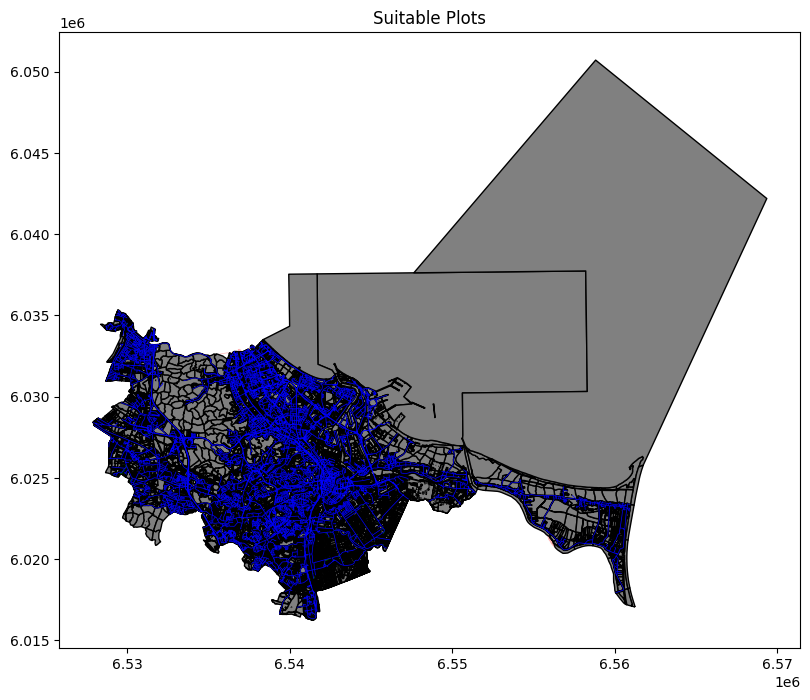

In [7]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
area_with_local_plan.plot(ax=ax, color='red', alpha=0.3)
plots.plot(ax=ax, color='grey', edgecolor='black')
potential_sites.plot(ax=ax, color='green')
buildings.plot(ax=ax, color='darkgrey', edgecolor='black')
residential_buildings.plot(ax=ax, color='black')
roads.plot(ax=ax, color='blue', linewidth=0.5)

plt.title('Suitable Plots')
plt.show()